### Загружаем текст и ищем, по какому символу разбить

In [1]:
with open("data/reviews.txt", "r") as file:
    text = file.read()
    
text = text.lstrip("INTELLIGENCE\n\n")

In [2]:
tokens = text.split()

In [3]:
from collections import Counter
c = Counter(tokens)
c.most_common(25)

Разбиваем

In [4]:
import re
reviews = [x.strip().lower() for x in re.split("1.215|1.214.1", text)]

In [5]:
reviews[:5]

['дискриминация собственников жилья. русофобы!!!',
 'ужас из за убранной возможности указывать национальность, костре приехали и чуть не избили нерусские за то что я им отказал! удаляю навсегда!!!!',
 'я буду сдавать квартиру,кому хочу и это буду славяне!🙋🏼\u200d♂️☀️ приложение ужасное,и проведайте там свои акции компании,как вы играете в толерастов и акции идут в упадок…',
 'спасибо циан! придется разговаривать с людьми, плохо знающими русский язык, которые хотят заселиться всем табуном в мою квартиру. спасибо, вы сами же и усложнили поиск квартиры иностранцам ближнего зарубежья, теперь им придется побегать и потрать кучу времени на поиск человека, которому безразлично на то, кому сдавать квартиру',
 'почему решать кому-то кому я хочу сдавать квартиру? почему решаете вы, что делать с моей собственностью, захочу только собакам сдавать буду, а захочу бригаду строителей, это не правила а бред.']

### Токенизируем: с нормализацией и без

In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np

In [7]:
import string
from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')
stop_words.extend([x for x in string.punctuation] + ["«", "»", "это", "!!!"])
stop_words.remove("только")

In [8]:
"только" in stop_words

False

In [9]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def normalize(x):
    return morph.parse(x)[0].normal_form

def extract_POS(x):
    return morph.parse(x)[0].tag.POS or "None"

In [10]:
normalize("славян")

'славянин'

In [11]:
tokenized_reviews = []
normalized_reviews = []

for r in reviews:
    tokens = [x for x in WordPunctTokenizer().tokenize(r) if x not in stop_words]
    tokenized_reviews.append(tokens)
    normalized_reviews.append([normalize(x) for x in tokens])

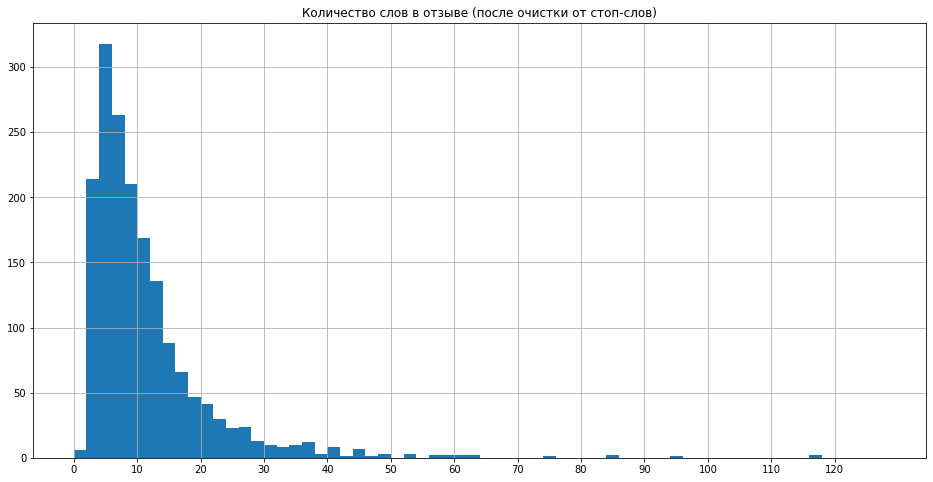

In [12]:
plt.figure(figsize=(16, 8))
plt.hist([len(x) for x in tokenized_reviews], bins=np.arange(0, 130, 2), rwidth=1)
plt.grid()
plt.title("Количество слов в отзыве (после очистки от стоп-слов)")
plt.xticks(np.arange(0, 130, 10))
plt.show()

In [13]:
POS_arr = []
for r in tokenized_reviews:
    POS_arr += [extract_POS(x) for x in r]

In [14]:
pos_counter = Counter(POS_arr)

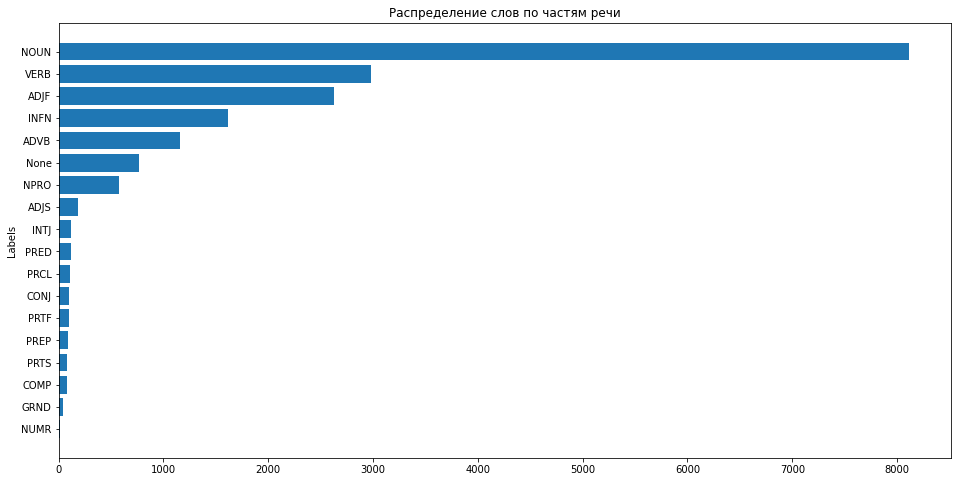

In [15]:
ntop = len(pos_counter)
xs = np.arange(len(pos_counter))
ys = [y for x, y in pos_counter.most_common(ntop)][::-1]
labels = [x for x, y in pos_counter.most_common(ntop)][::-1]

plt.figure(figsize=(16, 8))
plt.title("Распределение слов по частям речи")

plt.barh(xs, ys)
plt.yticks(xs, labels=[x + "" for x in labels])
plt.ylabel("Labels")
plt.show()

Расшифровка тэгов:
https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html#grammeme-docs

### Считаем частоты  n-грамм

In [16]:
def make_n_grams(arr, n, sep=" "):
    return [sep.join(arr[i:i+n]) for i in range(len(arr) - min(len(arr), n) + 1)]

In [17]:
N = 4

In [18]:
n_grams = defaultdict(list)
for tokens in tokenized_reviews:
    for i in range(1, N + 1):
        n_grams[i] += make_n_grams(tokens, i)

In [19]:
counters = {}
for key, value in n_grams.items():
    counters[key] = Counter(value)

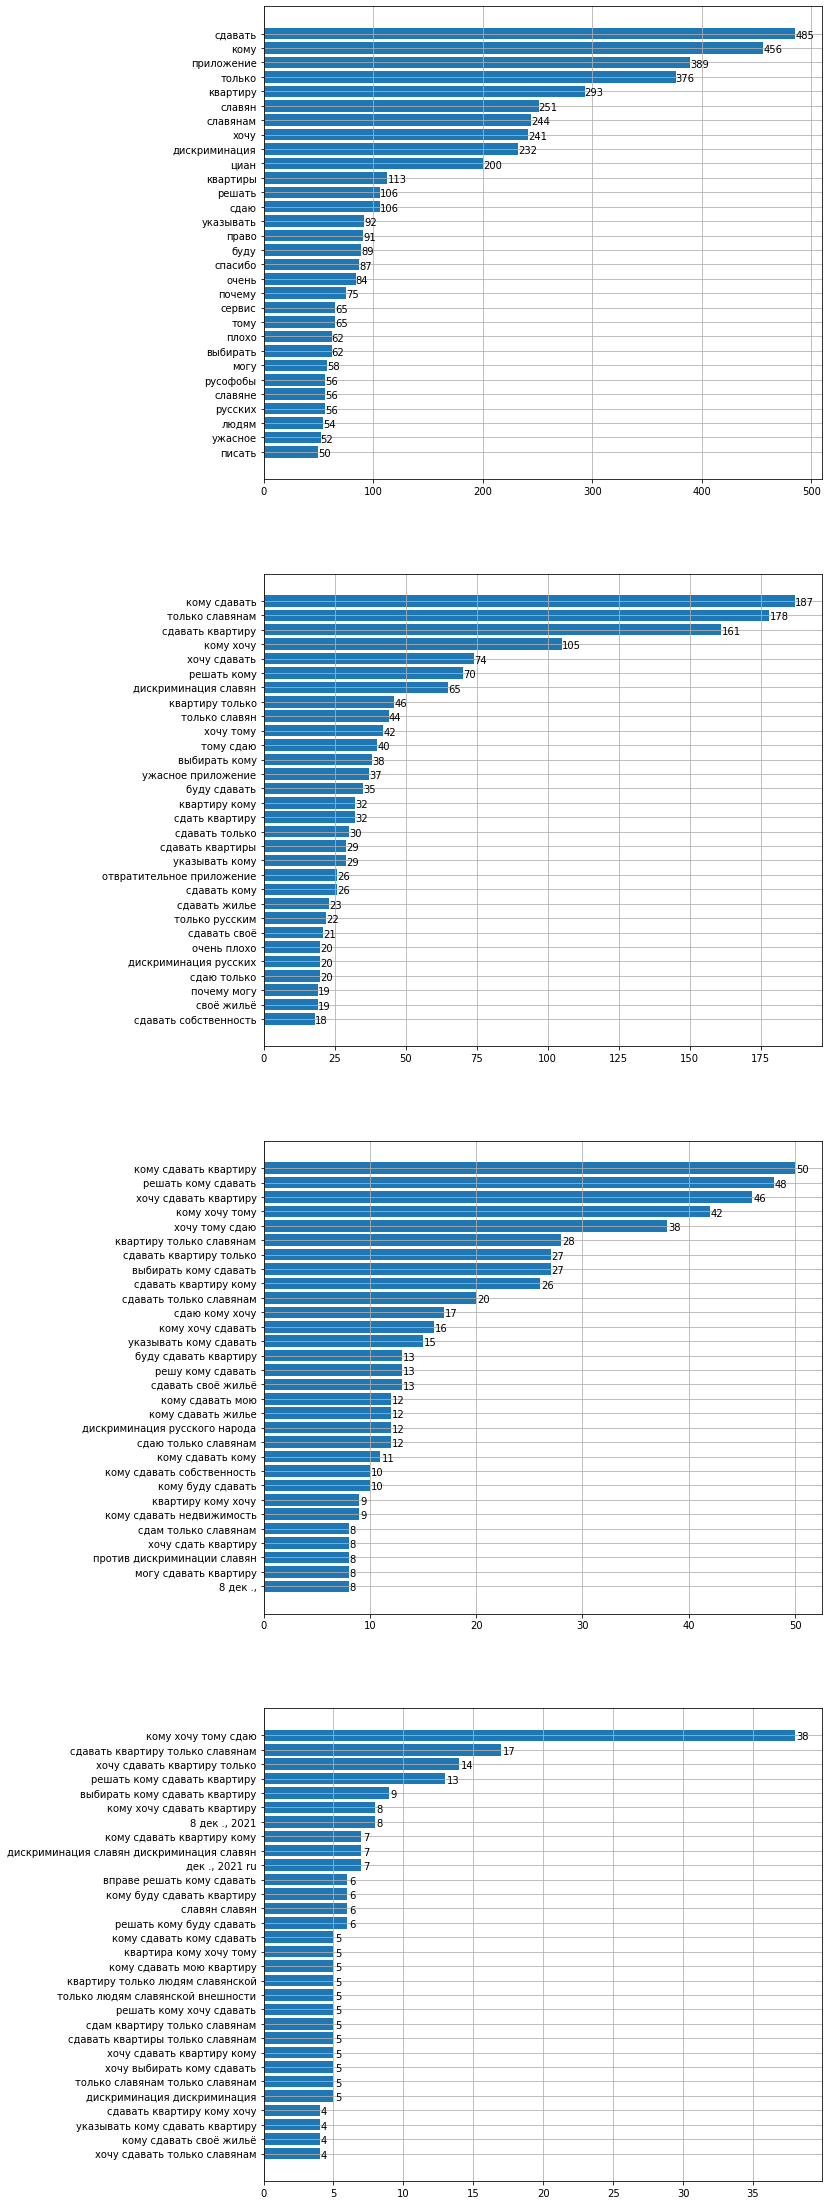

In [20]:
ncols = 1
nrows = math.ceil(N / ncols)
ntop = 30

fig, axs = plt.subplots(figsize=(10 * ncols, 10 * nrows), ncols=ncols, nrows=nrows)

keys = []

for i, key in enumerate(counters.keys()):
    ax = axs.reshape(-1)[i]
    xs = np.arange(ntop)
    ys = [y for x, y in counters[key].most_common(ntop)][::-1]
    labels = [x for x, y in counters[key].most_common(ntop)][::-1]
    ax.grid()
    ax.barh(xs, ys)
    ax.set_yticks(xs)
    ax.set_yticklabels(labels, rotation=0)
    for x, y in zip(xs, ys):
        ax.annotate(str(y), xy=(y, x), xytext=(y + 0.1, x - 0.3))

plt.show()

### То же самое, но с нормализацией

In [21]:
n_grams = defaultdict(list)
for tokens in normalized_reviews:
    for i in range(1, N + 1):
        n_grams[i] += make_n_grams(tokens, i)

In [22]:
counters = {}
for key, value in n_grams.items():
    counters[key] = Counter(value)

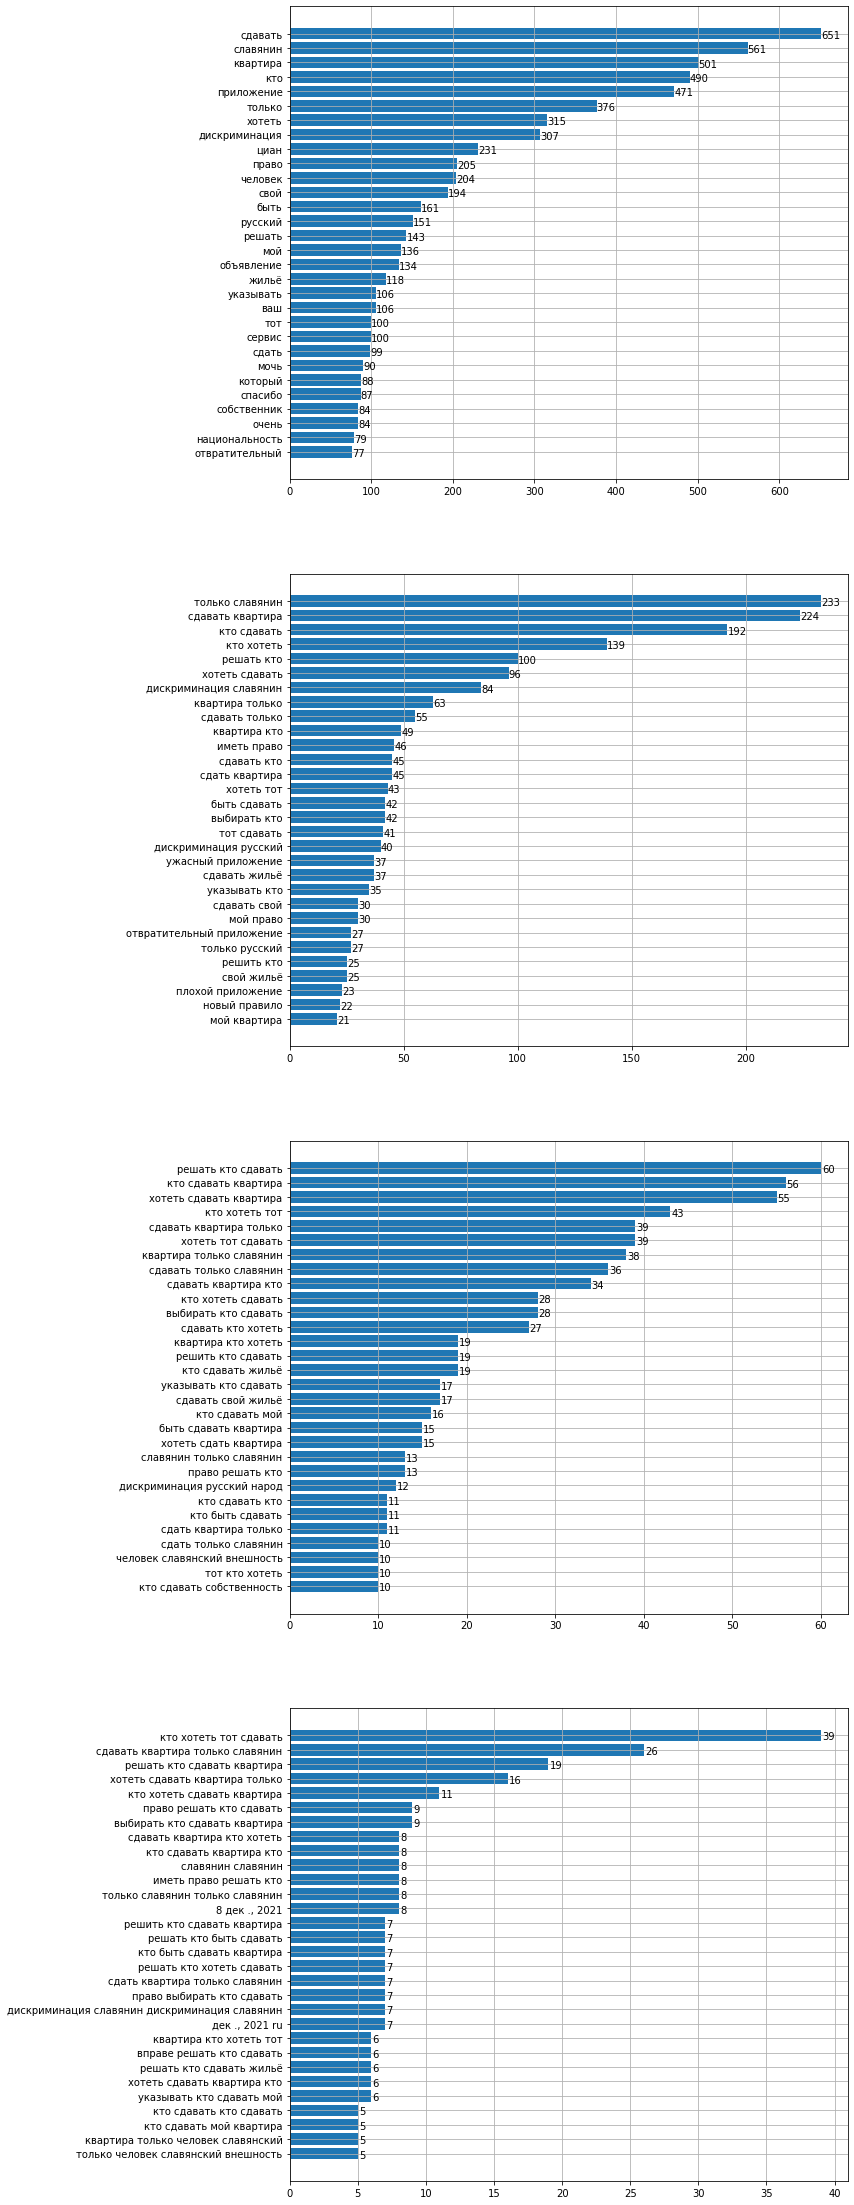

In [23]:
ncols = 1
nrows = math.ceil(N / ncols)
ntop = 30

fig, axs = plt.subplots(figsize=(10 * ncols, 10 * nrows), ncols=ncols, nrows=nrows)

keys = []

for i, key in enumerate(counters.keys()):
    ax = axs.reshape(-1)[i]
    xs = np.arange(ntop)
    ys = [y for x, y in counters[key].most_common(ntop)][::-1]
    labels = [x for x, y in counters[key].most_common(ntop)][::-1]
    ax.grid()
    ax.barh(xs, ys)
    ax.set_yticks(xs)
    ax.set_yticklabels(labels, rotation=0)
    for x, y in zip(xs, ys):
        ax.annotate(str(y), xy=(y, x), xytext=(y + 0.1, x - 0.3))

plt.show()

## Некоторые примеры

In [24]:
examples = [
    "славянин славянин",
    "дискриминация славянин дискриминация славянин"
]

dct = {x:[] for x in examples}

for i, x in enumerate(normalized_reviews):
    key = " ".join(x)
    if key in examples:
        dct[key].append(reviews[i])
        
for key, value in dct.items():
    print(key)
    for x in value:
        print("\t- " + x)
    print("---")

славянин славянин
	- славянам от славян
	- за славян за славян
	- за славян за славян
	- славян славян
	- за славян за славян
	- за славян за славян
	- за славян за славян
	- славяне славяне
---
дискриминация славянин дискриминация славянин
	- дискриминация славян дискриминация славян
	- дискриминация славян дискриминация славян
	- дискриминация славян дискриминация славян
	- дискриминация славян дискриминация славян
	- дискриминация славян дискриминация славян
	- дискриминация славян! дискриминация славян!
---


## Word Embeddings

In [25]:
import gensim.downloader

In [26]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [27]:
word_embeddings = gensim.downloader.load("word2vec-ruscorpora-300")

In [28]:
def review2vec(review, model):
    res = np.zeros(300)
    cnt = 0
    for word in review:
        pos = extract_POS(word)
        key = word + "_" + pos
        if key in model:
            res += model[key]
            cnt += 1
    return res / max(cnt, 1)

In [29]:
w2v_reviews = []
for r in normalized_reviews:
    w2v_reviews.append(review2vec(r, word_embeddings))

In [30]:
w2v_reviews = np.array(w2v_reviews)
w2v_reviews.shape

(1729, 300)

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=2)
pca_words = pca.fit_transform(w2v_reviews)

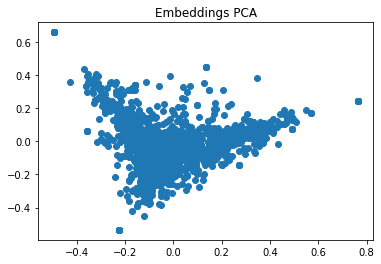

In [33]:
plt.scatter(pca_words[:, 0], pca_words[:, 1])
plt.title("Embeddings PCA")
plt.show()

In [34]:
from sklearn.cluster import DBSCAN, KMeans

In [57]:
eps = 1e-3
min_samples = 6

db = DBSCAN(eps=eps, metric="euclidean", min_samples=min_samples).fit(w2v_reviews)

labels = db.labels_
len(set(labels))

11

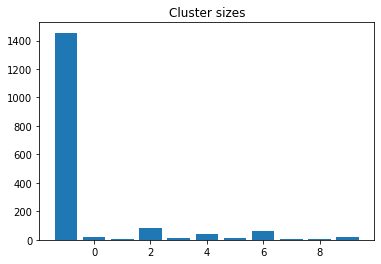

In [58]:
words = np.array(reviews)

clusters = {}
sizes = {}
for label in set(labels):
    cluster = words[labels == label]
    sizes[label] = len(cluster)
    clusters[label] = cluster
    
sizes_list = np.array(sorted([(x, y) for x,y in sizes.items()], key=lambda x: x[1], reverse=True))

plt.title("Cluster sizes")
plt.bar(sizes_list[:, 0], sizes_list[:, 1])
plt.show()

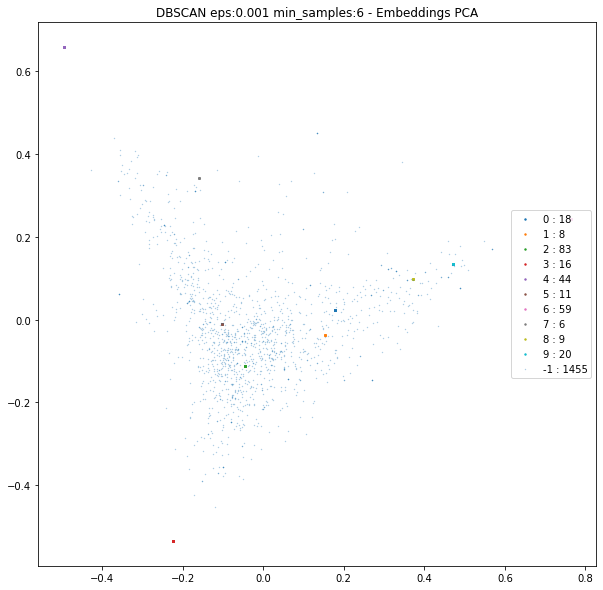

In [59]:
plt.figure(figsize=(10, 10))
for i in set(labels):
    s, a = (2, 1) if i != -1 else (0.1, 0.5)
    label = "{} : {}".format(i, sum(labels == i)) # if i != -1 else ""
    plt.scatter(
        pca_words[labels == i, 0], 
        pca_words[labels == i, 1],
        s=s,
        alpha=a,
        label=label)
plt.legend(loc=5)
plt.title("DBSCAN eps:{} min_samples:{} - Embeddings PCA".format(eps, min_samples))
plt.show()

In [63]:
n_top_clusters_to_plot = 1

sizes_to_plot = sizes_list[n_top_clusters_to_plot:, ]
sizes_to_plot = sizes_to_plot[sizes_to_plot[:, 1] > min_samples]

print("{} clusters cover {} reviews from {}".format(
    sizes_to_plot.shape[0],
    sum(sizes_to_plot[:, 1]),
    words.shape[0]
))

9 clusters cover 268 reviews from 1729


In [64]:
n_top_clusters_to_plot = 0

sizes_to_plot = sizes_list[n_top_clusters_to_plot:, ]
sizes_to_plot = sizes_to_plot[sizes_to_plot[:, 1] > min_samples]

print("{} clusters cover {} reviews from {}".format(
    sizes_to_plot.shape[0],
    sum(sizes_to_plot[:, 1]),
    words.shape[0]
))

10 clusters cover 1723 reviews from 1729


In [65]:
n_examples = 10

for x in sizes_to_plot:
    print("Label {}, Cluster size: {}".format(x[0], x[1]))
    for review in clusters[x[0]][:n_examples]:
        print("\t- " + review)
    print("\n")

Label -1, Cluster size: 1455
	- дискриминация собственников жилья. русофобы!!!
	- ужас из за убранной возможности указывать национальность, костре приехали и чуть не избили нерусские за то что я им отказал! удаляю навсегда!!!!
	- я буду сдавать квартиру,кому хочу и это буду славяне!🙋🏼‍♂️☀️ приложение ужасное,и проведайте там свои акции компании,как вы играете в толерастов и акции идут в упадок…
	- спасибо циан! придется разговаривать с людьми, плохо знающими русский язык, которые хотят заселиться всем табуном в мою квартиру. спасибо, вы сами же и усложнили поиск квартиры иностранцам ближнего зарубежья, теперь им придется побегать и потрать кучу времени на поиск человека, которому безразлично на то, кому сдавать квартиру
	- почему решать кому-то кому я хочу сдавать квартиру? почему решаете вы, что делать с моей собственностью, захочу только собакам сдавать буду, а захочу бригаду строителей, это не правила а бред.
	- как хочу, так и сдаю! прекращаю пользоваться данным приложением, из-за 